In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
sns.set_style("whitegrid")

In [203]:
class Assumption_Tester_OLS:
    """
    X - Pandas DataFrame with numerical values. Independent Variable
    y - Series with numerical values. Dependent Variable
    
    Tests a linear regression on the model to see if assumptions are being met

    """
    
    from sklearn.linear_model import LinearRegression
    
    def __init__(self, X,y):
        from numpy import ndarray
        from pandas import concat
        from pandas.core.frame import DataFrame
        from pandas.core.series import Series

        if type(X) == ndarray:
            self.features = ['X'+str(feature+1) for feature in range(X.shape[1])]
        elif type(X) == DataFrame:
            self.features=X.columns.to_list()
        else:
            print('Expected numpy array or pandas dataframe as X')
            return
        if type(y) == ndarray:
            self.output = 'y'
        elif type(y) == DataFrame:
            self.output=y.columns[0]
        elif type(y) == Series:
            self.output=y.name
        else:
            print('Expected numpy array or pandas dataframe as X')
            return

        self.X = X.values if type(X)==DataFrame else X
        self.y=y.iloc[:,0].values if type(y)==DataFrame else y.values if type(y)==Series else y
        
        self.model='not built yet'
        self.r2=0
        self.results={'Satisfied':[],'Potentially':[],'Violated':[]}
    
    def fit_model(self):
        from sklearn.linear_model import LinearRegression
        
        print('Fitting linear regression')        
        
        #Multi-threading when needed
        if self.X.shape[0] > 100000:
            self.model = LinearRegression(n_jobs=-1)
        else:
            self.model = LinearRegression()
        self.model.fit(self.X, self.y)
        
        self.predictions = self.model.predict(self.X)
        self.resid = self.y - self.predictions
        
        
    def build_model(self):
        self.fit_model()
        
        # Returning linear regression R^2 and coefficients before performing diagnostics
        self.r2 = self.model.score(self.X, self.y)
        print()
        print('R^2:', self.r2, '\n')
        print('Coefficients')
        print('-------------------------------------')
        print('Intercept:', self.model.intercept_)
        for idx,feature in enumerate(self.model.coef_):
            print(f'{self.features[idx]}: {round(feature,2)}')

    def linearity(self):
        """
        Linearity: Assumes there is a linear relationship between the predictors and
                   the response variable. If not, either a polynomial term or another
                   algorithm should be used.
        """
        from pandas import concat
        from numpy import arange
        from pandas.core.frame import DataFrame
        from pandas.core.series import Series        
        import seaborn as sns
        sns.set()
        import matplotlib.pyplot as plt
        
        if type(self.model)==str:
            self.fit_model()
        
        print('\n=======================================================================================')
        print('Assumption 1: Linear Relationship between the Target and the Features')
        print('Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.')
        
        # Plotting the actual vs predicted values
        sns.regplot(self.y,self.predictions, fit_reg=False)
        
        # Plotting the diagonal line
        line_coords = arange(min(self.y.min(),self.predictions.min()), max(self.y.max(),self.predictions.max()))
        plt.plot(line_coords, line_coords,  # X and y points
                 color='darkorange', linestyle='--')
        plt.title('Actual vs. Predicted')
        plt.show()
        print('If non-linearity is apparent, consider adding a polynomial term \n\t\tor using box-cox transformation to make X or y follow normal distribution')
        
        print('\n\n\nBuilding a correlation table')
        print('\n=======================================================================================')
        df=concat([DataFrame(self.X),Series(self.y)],axis=1)
        df.columns=self.features+[self.output]
        df_corr=df[df.nunique()[df.nunique()>2].index].corr()[self.output].drop(self.output)
        
        print(f'\nParameters that are most likely VIOLATE linearity assumption and their correlation with {self.output}')
        display(df_corr[abs(df_corr)<0.25])

        print(f'\nParameters that are most likely FOLLOW linearity assumption and their correlation with {self.output}')
        display(df_corr[abs(df_corr)>=0.25])
        
        
        if df_corr[abs(df_corr)<0.25].shape[0]==0:
            self.results['Satisfied'].append('Linearity')
        elif df_corr[abs(df_corr)>=0.25].shape[0]==0:
            self.results['Violated'].append('Linearity')
        else:
            self.results['Potentially'].append('Linearity')
        
    def multicollinearity(self):
        """
        Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                           correlation among the predictors, then either remove prepdictors with high
                           Variance Inflation Factor (VIF) values or perform dimensionality reduction
                           This assumption being violated causes issues with interpretability of the 
                           coefficients and the standard errors of the coefficients.
        """
        from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
        import matplotlib.pyplot as plt
        import seaborn as sns
        from pandas.core.frame import DataFrame
        sns.set()
        
        if type(self.model)==str:
            self.fit_model()
            
        print('\n=======================================================================================')
        print('Assumption 2: Little to no multicollinearity among predictors')
        # Plotting the heatmap
        plt.figure(figsize = (10,8))
        sns.heatmap(DataFrame(self.X, columns=self.features).corr(), annot=len(self.features)<10, center=0, cmap=sns.diverging_palette(220, 20, as_cmap=True))
        plt.title('Correlation of Variables')
        plt.show()
        print('Variance Inflation Factors (VIF)')
        print('> 10: An indication that multicollinearity may be present')
        print('> 100: Certain multicollinearity among the variables')
        print('-------------------------------------')
        # Gathering the VIF for each variable
        vifs = {i:VIF(self.X, idx) for idx,i in enumerate(self.features)}
        vifs = dict(sorted(vifs.items(), key=lambda x: x[1], reverse=True))
        for key, vif in vifs.items():
            print(f'{key}: {vif}')
        # Gathering and printing total cases of possible or definite multicollinearity
        possible_multicollinearity = sum([1 for vif in vifs.values() if vif > 10])
        definite_multicollinearity = sum([1 for vif in vifs.values() if vif > 100])
        print()
        print(f'{possible_multicollinearity} cases of possible multicollinearity')
        print(f'{definite_multicollinearity} cases of definite multicollinearity')
        print()
        if definite_multicollinearity == 0:
            if possible_multicollinearity == 0:
                print('Assumption satisfied')
                self.results['Satisfied'].append('Multicollinearity')
            else:
                print('Assumption possibly satisfied')
                print()
                print('Coefficient interpretability may be problematic')
                print('Consider removing variables with a high Variance Inflation Factor (VIF)')
                self.results['Potentially'].append('Multicollinearity')

        else:
            print('Assumption not satisfied')
            print()
            print('Coefficient interpretability will be problematic')
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')
            self.results['Violated'].append('Multicollinearity')
            

    
    def autocorrelation(self):
        """
        Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                         autocorrelation, then there is a pattern that is not explained due to
                         the current value being dependent on the previous value.
                         This may be resolved by adding a lag variable of either the dependent
                         variable or some of the predictors.
        """
        from statsmodels.stats.stattools import durbin_watson        
        
        if type(self.model)==str:
            self.fit_model()
        print('\n=======================================================================================')
        print('Assumption 3: No Autocorrelation')
        print('\nPerforming Durbin-Watson Test')
        print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
        print('0 to 2< is positive autocorrelation')
        print('>2 to 4 is negative autocorrelation')
        print('-------------------------------------')
        durbinWatson = durbin_watson(self.resid)
        print('Durbin-Watson:', durbinWatson)
        if durbinWatson < 1.5:
            print('Signs of positive autocorrelation', '\n')
            print('Assumption not satisfied', '\n')
            self.results['Violated'].append('Autocorrelation')
        elif durbinWatson > 2.5:
            print('Signs of negative autocorrelation', '\n')
            print('Assumption not satisfied', '\n')
            self.results['Violated'].append('Autocorrelation')
        else:
            print('Little to no autocorrelation', '\n')
            print('Assumption satisfied')
            self.results['Satisfied'].append('Autocorrelation')
            

    def homoskedasticity(self,p_value_thresh=0.05):
        """
        Homoskedasticity: Assumes that the errors exhibit constant variance
        """
        
        from statsmodels.stats.diagnostic import het_breuschpagan
        
        import matplotlib.pyplot as plt
        import seaborn
        from numpy import repeat
        seaborn.set()
        
        if type(self.model)==str:
            self.fit_model()
            
        print('\n=======================================================================================')
        print('Assumption 4: Homoskedasticity of Error Terms')
        print('Residuals should have relative constant variance')
        # Plotting the residuals
        plt.subplots(figsize=(12, 6))
        ax = plt.subplot(111)  # To remove spines
        plt.scatter(x=range(self.X.shape[0]), y=self.resid, alpha=0.5)
        plt.plot(repeat(0, self.X.shape[0]), color='darkorange', linestyle='--')
        ax.spines['right'].set_visible(False)  # Removing the right spine
        ax.spines['top'].set_visible(False)  # Removing the top spine
        plt.title('Residuals')
        plt.show() 
        print('If heteroskedasticity is apparent, confidence intervals and predictions will be affected')        
        print('\nConsider removing outliers and preprocessing features - nonlinear transformation can help')
        
        lnames=['Lagrange Multiplier', 'pvalue for LM','F stats','pvalue for Fstats']
        display({lnames[idx]:het_breuschpagan(self.resid,self.X)[idx] for idx in range(4)})
        if het_breuschpagan(self.resid,self.X)[3] < p_value_thresh:
            print('Signs of positive autocorrelation', '\n')
            print('Assumption potentially not satisfied', '\n')
            self.results['Potentially'].append('Autocorrelation')
        else:
            print('Signs of negative autocorrelation', '\n')
            print('Assumption satisfied', '\n')
            self.results['Satisfied'].append('Autocorrelation')

       
        
    def normality_resid(self,p_value_thresh=0.05):
        """
        Normality: Assumes that the error terms are normally distributed. If they are not,
        nonlinear transformations of variables may solve this.
        This assumption being violated primarily causes issues with the confidence intervals
        """
        from statsmodels.stats.diagnostic import normal_ad
        from scipy.stats import probplot
        import pylab
        import matplotlib.pyplot as plt
        import seaborn as sns
        from numpy import quantile,logical_or
        sns.set()

        if type(self.model)==str:
            self.fit_model()
            
        print('\n=======================================================================================')
        print('Assumption 5: The error terms are kinda normally distributed')
        print()
        print('Using the Anderson-Darling test for normal distribution')
        # Performing the test on the residuals
        p_value = normal_ad(self.resid)[1]
        print('p-value from the test - below 0.05 generally means non-normal:', p_value)
        # Reporting the normality of the residuals
        if p_value < p_value_thresh:
            print('Residuals are not normally distributed')
        else:
            print('Residuals are normally distributed')
        # Plotting the residuals distribution
        plt.subplots(figsize=(12, 6))
        plt.title('Distribution of Residuals')
        sns.distplot(self.resid)
        plt.show()
        print()
        if p_value > p_value_thresh:
            print('Assumption satisfied')
            self.results['Satisfied'].append('Normality')
        else:
            print('Assumption not satisfied')
            self.results['Violated'].append('Normality')
            print()
            print('Confidence intervals will likely be affected')
            print('Try performing nonlinear transformations on variables')
    
    
        print('Building a probability plot')
        quantiles=probplot(self.resid, dist='norm', plot=pylab);
        plt.show()
        qqq=(quantiles[0][1]-quantiles[0][1].mean())/quantiles[0][1].std()-quantiles[0][0]
        q75=quantile(qqq,0.75)
        q25=quantile(qqq,0.25)

        outliers_share=(logical_or(qqq>q75+(q75-q25)*1.7, qqq<q25-(q75-q25)*1.7).sum()/qqq.shape[0]).round(3)
        if outliers_share<0.005:
            print('Assumption can be considered as satisfied.')
            self.results['Satisfied'].append('Sub-Normality')
        elif outliers_share<0.05:
            self.results['Potentially'].append('Sub-Normality')
            print(f'\nIn your dataset you quite fat tails. You have {outliers_share} potential outliers ({logical_or(qqq>q75+(q75-q25)*1.7, qqq<q25-(q75-q25)*1.7).sum()} rows)')
        else:
            print(f'\nIn fact outliers are super significant. Probably it is better to split your dataset into 2 different ones.')
            self.results['Violated'].append('Sub-Normality')


    def run_all(self):
        self.build_model()
        self.linearity()
        self.multicollinearity()
        self.autocorrelation()
        self.homoskedasticity()
        self.normality_resid()
        display(self.results)




In [2]:
dataBook=pd.read_csv('/Users/sandrine//Desktop/Prework/Projects_Ironhack/Book_loan/docprets.csv',sep=';')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Objectif : Analyse Book loan trends of Parisian people and predict number of Loan per books

In [ ]:
""" Loan may depend on:
Book "Age"(accessible via Year column), 
the librairie and its stock,
the author,
the publisher (column Editeur)
the format

In [3]:
dataBook.head()

,N° de notice,ISBN,ISSN,EAN,Langue,Titre,Edition,Editeur,Date,Format,...,Vaclav Havel,Valeyre,Vandamme,Vaugirard,Auteur,Co-auteur,Auteur secondaire,Collectivité auteur,Collectivité auteur secondaire,Collectivité co-auteur
0,176870,NaN,NaN,NaN,français,La Politique étrangère en France | Texte impri...,NaN,Documentation française ;Ministère des affaire...,2003,386 p. | 28 cm,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FRANCE. Direction de la documentation française,France. Ministère des relations extérieures;Di...,NaN
1,176733,2-8435-2107-6,NaN,NaN,français,Voyages en Sicile | Texte imprimé | Dominique ...,NaN,"Diderot éditeur, arts et sciences",1998,1 vol. (299 p.) | 18 cm,...,NaN,NaN,NaN,NaN,"Denon, Dominique Vivant",NaN,NaN,NaN,NaN,NaN
2,176766,2-259-00278-1,NaN,NaN,français,0Voyages | [2] | Russie | Texte imprimé | Niko...,NaN,Plon,1977,322 p.-[1] f. de pl. | 20 cm,...,NaN,NaN,NaN,NaN,"Kazantzákīs, Níkos",NaN,"Princet, Liliane",NaN,NaN,NaN
3,176779,NaN,NaN,NaN,français,L'harmonica blues pour débutants | Texte imprimé,NaN,Emf,1997,1 méthode musicale (62 p.) | 30 cm | éventuell...,...,NaN,NaN,NaN,NaN,"Kinsella, Mick",NaN,NaN,NaN,NaN,NaN
4,176892,0-06-443063-4,NaN,NaN,anglais,A letter to Amy | Texte imprimé | Ezra Jack Keats,NaN,Harper Trophy,1984,30 p. | ill. en coul. | 21 cm,...,NaN,NaN,NaN,NaN,"Keats, Ezra Jack",NaN,NaN,NaN,NaN,NaN


In [4]:
#Check general info from DataFrame
dataBook.shape,dataBook.dtypes

((815534, 103),
 N° de notice                        int64
 ISBN                               object
 ISSN                               object
 EAN                                object
 Langue                             object
                                     ...  
 Co-auteur                          object
 Auteur secondaire                  object
 Collectivité auteur                object
 Collectivité auteur secondaire     object
 Collectivité co-auteur             object
 Length: 103, dtype: object)

In [5]:
#Replace ' ' by '_in column names'
dataBook.columns=dataBook.columns.str.replace(' ','_')
dataBook.columns.to_list()

['N°_de_notice',
 'ISBN',
 'ISSN',
 'EAN',
 'Langue',
 'Titre',
 'Edition',
 'Editeur',
 'Date',
 'Format',
 'Collection',
 'Titre_de_série',
 'N°',
 'Auteur_Nom',
 'Auteur_Prénom',
 'Auteur_Dates',
 'Co-auteur_Nom',
 'Co-auteur_Prénom',
 'Dates',
 'Auteur_secondaire_Nom',
 'Auteur_secondaire_Prénom',
 'Auteur_secondaire_Dates',
 'Auteur_collectivité',
 'Subdivision_auteur_collectivité',
 'Co-auteur_collectivité',
 'Subdivision_co-auteur_collectivité',
 'Auteur_secondaire_collectivité',
 'Subdivision_auteur_secondaire_collectivité',
 'Indice',
 'Cote_majoritaire',
 'Type_de_document',
 'Nombre_de_localisations',
 'Nombre_de_prêt_total',
 'Nombre_de_prêts_2017',
 'Nombre_de_prêt_année_2018_au_26_juillet_2018',
 "Nombre_d'exemplaires",
 'Catégorie_statistique_1',
 'Catégorie_statistique_2',
 'Aimé_Césaire',
 'Amélie',
 'André_Malraux',
 'Andrée_Chedid',
 'Arthur_Rimbaud',
 'Assia_Djebar',
 'Batignolles',
 'Benjamin_Rabier',
 'Buffon',
 'Canopée_-_la_fontaine',
 'Chaptal',
 'Charlotte_Del

In [6]:
dataBook['N°_de_notice'].unique().size==dataBook.shape[0]
#N°_de_notice could be an index for the dataset

True

In [7]:
# Prepare list of columns to drop due to missing values
to_drop=[]
to_drop.extend(dataBook.iloc[:,100:103].columns.to_list())
#Prepare list of columns for which we want to get dummies
Dummies_NA=[]
row_to_drop=[]

# NULL VALUES TREATMENT

In [8]:
#Check Number of Null values per columns
dataBook.isna().sum().to_dict()

{'N°_de_notice': 0,
 'ISBN': 323243,
 'ISSN': 813046,
 'EAN': 416532,
 'Langue': 81024,
 'Titre': 0,
 'Edition': 753989,
 'Editeur': 5012,
 'Date': 4727,
 'Format': 9126,
 'Collection': 452201,
 'Titre_de_série': 731570,
 'N°': 747164,
 'Auteur_Nom': 195970,
 'Auteur_Prénom': 226043,
 'Auteur_Dates': 479400,
 'Co-auteur_Nom': 742303,
 'Co-auteur_Prénom': 745706,
 'Dates': 780798,
 'Auteur_secondaire_Nom': 434722,
 'Auteur_secondaire_Prénom': 445681,
 'Auteur_secondaire_Dates': 643727,
 'Auteur_collectivité': 778776,
 'Subdivision_auteur_collectivité': 814619,
 'Co-auteur_collectivité': 812310,
 'Subdivision_co-auteur_collectivité': 815398,
 'Auteur_secondaire_collectivité': 734528,
 'Subdivision_auteur_secondaire_collectivité': 812303,
 'Indice': 382046,
 'Cote_majoritaire': 3,
 'Type_de_document': 2,
 'Nombre_de_localisations': 1,
 'Nombre_de_prêt_total': 36674,
 'Nombre_de_prêts_2017': 3,
 'Nombre_de_prêt_année_2018_au_26_juillet_2018': 44298,
 "Nombre_d'exemplaires": 3,
 'Catégorie_

In [9]:
#dataBook["Auteur_Dates"].value_counts()
#Column not necessary for the model so I drop it.
to_drop.append('Auteur_Dates')

In [10]:
#check whether I can drop or replace 'Auteur', 'Auteur Prenom' and 'Auteur Nom' columns
dftest=dataBook[(dataBook['Auteur_Nom']+', '+dataBook['Auteur_Prénom'])!=dataBook['Auteur']]
df=dftest[(dftest['Auteur_Nom']==dftest['Auteur'])|(dftest['Auteur_Prénom']==dftest['Auteur'])]
df[['Auteur_Nom','Auteur_Prénom','Auteur']]

df1=dftest[(dftest['Auteur_Nom']!=dftest['Auteur'])&(dftest['Auteur_Prénom']!=dftest['Auteur'])]
df1[['Auteur_Nom','Auteur_Prénom','Auteur']]
df1['Auteur_Prénom'].isna().sum()==df1['Auteur_Nom'].isna().sum()==df1['Auteur'].isna().sum()
#Author column is a mix of columns 'Auteur_Nom' and 'Auteur_Prénom' . However the format of Author does not
#suit me.


True

In [11]:
def merge_authors(x):
    if ';' in x:
        y=x.split('|')
        z=[i for i in zip(y[0].split(';'),y[1].split(';'))]
        w=[' '.join(i) for i in z]
        return w
    else:
        w=x.replace("|", " ")
        return w
    
authors="Watson;Stephen;Padmore;Varcoe;Hickox,|Janice;Pamela Helen;Mark;Stephen;Richard"
test='Liliane|Princet'
y=merge_authors(authors)
y

['Watson Janice',
 'Stephen Pamela Helen',
 'Padmore Mark',
 'Varcoe Stephen',
 'Hickox, Richard']

In [12]:
# I will create a  new column for Author.
dataBook['Author']=dataBook['Auteur_Prénom']+'|'+dataBook['Auteur_Nom']
dataBook['Author'].fillna('UnknownAuthor',inplace=True)
dataBook['Author']=dataBook['Author'].map(lambda x : merge_authors(x))
#dataBook[dataBook['Author'].isna()]


In [13]:
to_drop.extend(['Auteur_Prénom','Auteur_Nom','Auteur'])

In [ ]:
#check whether I can drop or replace 'Auteur_secondaire_Nom', 'Auteur_secondaire_Prénom' 
#and 'Auteur_secondaire' columns. Auteur secondaire include translaters.
#df3=dataBook[(dataBook['Auteur_secondaire_Nom']+', '+dataBook['Auteur_secondaire_Prénom'])!=dataBook['Auteur_secondaire']]
#df3[['Auteur_secondaire_Nom','Auteur_secondaire_Prénom','Auteur_secondaire']]
# same conclusions as for Author.

In [14]:
# I will create a  new column for Secondary Author.

dataBook['Author_secondary']=dataBook['Auteur_secondaire_Prénom']+'|'+dataBook['Auteur_secondaire_Nom']
dataBook['Author_secondary'].fillna('UnknownAuthor',inplace=True)
dataBook['Author_secondary']=dataBook['Author_secondary'].map(lambda x : merge_authors(x))

In [15]:
to_drop.extend(['Auteur_secondaire_Prénom','Auteur_secondaire_Nom','Auteur_secondaire'])

In [ ]:
#dataBook["Co-auteur_Nom"].value_counts()

In [16]:
# I will create a  new column for Co Author Author.

dataBook['Co_Author']=dataBook['Co-auteur_Prénom']+'|'+dataBook['Co-auteur_Nom']
dataBook['Co_Author'].fillna('UnknownAuthor',inplace=True)
dataBook['Co_Author']=dataBook['Co_Author'].map(lambda x : merge_authors(x))

In [17]:
to_drop.extend(['Co-auteur_Prénom','Co-auteur_Nom'])

In [18]:
#dataBook[dataBook['N°_de_notice']==176958].to_dict()

In [19]:
#dataBook["Auteur_secondaire_Dates"].value_counts()
to_drop.append('Auteur_secondaire_Dates')

In [20]:
# Avoir si je droppe ou si cela a un intérêt plus tard.

to_drop.extend(['Auteur_collectivité','Subdivision_auteur_collectivité','Co-auteur_collectivité','Subdivision_co-auteur_collectivité','Auteur_secondaire_collectivité','Subdivision_auteur_secondaire_collectivité'])



In [ ]:
#dataBook["Subdivision_auteur_secondaire_collectivité"].value_counts()

In [ ]:
#dataBook["Indice"].value_counts()

In [ ]:
#dataBook[dataBook["Indice"]=='914.3;320.943;330.943']

In [21]:
to_drop.append('Indice')

In [25]:
#dataBook['Nombre_de_localisations'].value_counts()
dataBook[dataBook['Nombre_de_localisations'].isna()]
dataBook.loc[283847]
#after dropping row loc[283847]. this column should not have missing values anymore.

N°_de_notice                              891370
ISBN                                         NaN
ISSN                                         NaN
EAN                                 743217828028
Langue                                  allemand
                                       ...      
Collectivité_auteur_secondaire_              NaN
Collectivité_co-auteur_                      NaN
Author                             UnknownAuthor
Author_secondary                   UnknownAuthor
Co_Author                          UnknownAuthor
Name: 283847, Length: 106, dtype: object

In [23]:
#dataBook['Nombre_de_prêt_total'].value_counts()
#dataBook[dataBook['Nombre_de_prêt_total']==6930.0].T.to_dict()
#dataBook[dataBook['Nombre_de_prêt_total'].isna()]['Nombre_de_prêt_année_2018_au_26_juillet_2018'].sum()
# put 0 wjen missing value for "Nombre de pret total after checking 2017 and 2018 values which are at 0"
dataBook['Nombre_de_prêt_total'].fillna('0',inplace=True)

In [24]:
# check if change is ok.
dataBook['Nombre_de_prêt_total'].isna().sum()

0

In [26]:
#dataBook['Nombre_de_prêts_2017'].value_counts()
#dataBook[dataBook['Nombre_de_prêts_2017']==1114.0].T.to_dict()
dataBook[dataBook['Nombre_de_prêts_2017'].isna()]['Nombre_de_prêt_année_2018_au_26_juillet_2018']
# put 0 when missing value for "Nombre de pret total after checking and 2018 values which are at 0"
dataBook['Nombre_de_prêts_2017'].fillna('0',inplace=True)

In [27]:
# check if change is ok.
dataBook['Nombre_de_prêts_2017'].isna().sum()

0

In [28]:
#dataBook["Nombre_d'exemplaires"].value_counts()
#dataBook[dataBook["Nombre_d'exemplaires"]==1149.0 ].T.to_dict()
dataBook[dataBook["Nombre_d'exemplaires"].isna()]
# put 0 when missing value for 
dataBook["Nombre_d'exemplaires"].fillna('0',inplace=True)

In [29]:
# check if change is ok.
dataBook["Nombre_d'exemplaires"].isna().sum()

0

In [30]:
#dataBook["Catégorie_statistique_1"].value_counts().sum()
#dataBook[dataBook["Catégorie_statistique_1"].isna()]["Nombre_d'exemplaires"]
# no stock available==> drop the row
dataBook[dataBook["Catégorie_statistique_1"].isna()]

,N°_de_notice,ISBN,ISSN,EAN,Langue,Titre,Edition,Editeur,Date,Format,...,Vaugirard,Auteur,Co-auteur,Auteur_secondaire,Collectivité_auteur,Collectivité_auteur_secondaire_,Collectivité_co-auteur_,Author,Author_secondary,Co_Author
252063,325759,2-226-08797-4,NaN,NaN,français,"Amen ! | Texte imprimé | Liberatore, Tamburini...",NaN,L'Écho des savanes;A. Michel\t1996\t51 p. | il...,pas de code stat 2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UnknownAuthor,UnknownAuthor,UnknownAuthor
283847,891370,NaN,NaN,743217828028,allemand,Bis an alle Sterne'' | Enregistrement sonore |...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UnknownAuthor,UnknownAuthor,UnknownAuthor
722429,128091,2-900130-97-2,NaN,NaN,français,La savetiere prodigieuse | mise en scène de St...,NaN,"L'avant-scène\t2005\t92 p. | ill., couv. ill. ...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,128150. '320.97 CUB,320.972,UnknownAuthor,UnknownAuthor,UnknownAuthor


In [31]:
#Row to drop by N°_de_notice

row_to_drop.append(891370)
row_to_drop

[891370]

In [32]:
row_to_drop.extend([325759,128091])

In [33]:
dataBook["Catégorie_statistique_2"].value_counts()
# 688882 records without any specifique code stat 2.
# But  column can help to fill in missing values or error in other column
dataBook[dataBook["Catégorie_statistique_2"].isna()] 
# same 3 rows to drop.


,N°_de_notice,ISBN,ISSN,EAN,Langue,Titre,Edition,Editeur,Date,Format,...,Vaugirard,Auteur,Co-auteur,Auteur_secondaire,Collectivité_auteur,Collectivité_auteur_secondaire_,Collectivité_co-auteur_,Author,Author_secondary,Co_Author
252063,325759,2-226-08797-4,NaN,NaN,français,"Amen ! | Texte imprimé | Liberatore, Tamburini...",NaN,L'Écho des savanes;A. Michel\t1996\t51 p. | il...,pas de code stat 2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UnknownAuthor,UnknownAuthor,UnknownAuthor
283847,891370,NaN,NaN,743217828028,allemand,Bis an alle Sterne'' | Enregistrement sonore |...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UnknownAuthor,UnknownAuthor,UnknownAuthor
722429,128091,2-900130-97-2,NaN,NaN,français,La savetiere prodigieuse | mise en scène de St...,NaN,"L'avant-scène\t2005\t92 p. | ill., couv. ill. ...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,128150. '320.97 CUB,320.972,UnknownAuthor,UnknownAuthor,UnknownAuthor


In [34]:
dataBook[dataBook["Type_de_document"].isna()]
# same rows to drop.

,N°_de_notice,ISBN,ISSN,EAN,Langue,Titre,Edition,Editeur,Date,Format,...,Vaugirard,Auteur,Co-auteur,Auteur_secondaire,Collectivité_auteur,Collectivité_auteur_secondaire_,Collectivité_co-auteur_,Author,Author_secondary,Co_Author
252063,325759,2-226-08797-4,NaN,NaN,français,"Amen ! | Texte imprimé | Liberatore, Tamburini...",NaN,L'Écho des savanes;A. Michel\t1996\t51 p. | il...,pas de code stat 2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UnknownAuthor,UnknownAuthor,UnknownAuthor
283847,891370,NaN,NaN,743217828028,allemand,Bis an alle Sterne'' | Enregistrement sonore |...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UnknownAuthor,UnknownAuthor,UnknownAuthor


In [35]:
dataBook["Type_de_document"].value_counts().to_dict()

{'Livre pour adulte': 339488,
 'Disque compact': 189910,
 'Livre jeunesse': 86091,
 'DVD-vidéo tous publics': 43654,
 'Bande dessinée pour adulte': 27462,
 'Livre en langue étrangère': 22714,
 'Partition': 19178,
 'Bande dessinée jeunesse': 15219,
 'Livre de Fonds spécialisés': 15001,
 'DVD jeunesse': 8788,
 'Livre sonore pour adulte': 7119,
 'Méthode de langue': 5751,
 'Enregistrement musical pour la jeunesse': 5095,
 'Méthode musicale': 3947,
 'Usuels': 3802,
 'Livre en gros caractères': 3519,
 'DVD- vidéo > 12 ans': 3256,
 'Livre sonore jeunesse': 2943,
 'Livre de section jeunesse > 12 ans': 2045,
 'Vinyle': 1620,
 'Carte ou plan': 1286,
 'Revue pour adulte': 1156,
 'Non empruntable': 1045,
 'DVD-vidéo > 16 ans': 1001,
 'Livres et périodiques DAISY': 729,
 'Revue jeunesse': 700,
 'Diapositives jeunesse': 537,
 'Jeux Vidéos tous publics': 510,
 'Jeux de société': 419,
 'Bande dessinée jeunesse >12 ans': 404,
 'Revue de Fonds spécialisés': 211,
 'Nouveauté': 154,
 'Nouveauté disque co

In [36]:
dict_map={'Livre pour adulte': 'Book',
 'Disque compact': 'CD',
 'Livre jeunesse': 'Book',
 'DVD-vidéo tous publics': 'DVD',
 'Bande dessinée pour adulte': 'BD',
 'Livre en langue étrangère': 'Book',
 'Partition': 'Partition',
 'Bande dessinée jeunesse': 'BD',
 'Livre de Fonds spécialisés': 'Book',
 'DVD jeunesse': 'DVD',
 'Livre sonore pour adulte': 'Book',
 'Méthode de langue': 'Other',
 'Enregistrement musical pour la jeunesse': 'CD',
 'Méthode musicale': 'Partition',
 'Usuels': 'Book',
 'Livre en gros caractères': 'Book',
 'DVD- vidéo > 12 ans': 'DVD',
 'Livre sonore jeunesse': 'Book',
 'Livre de section jeunesse > 12 ans': 'Book',
 'Vinyle': 'Vynile',
 'Carte ou plan': 'Map',
 'Revue pour adulte': 'Magazine',
 'Non empruntable': 'Cannot_be_borrowed',
 'DVD-vidéo > 16 ans':'DVD',
 'Livres et périodiques DAISY': 'Other',
 'Revue jeunesse': 'Magazine',
 'Diapositives jeunesse': 'Diapo',
 'Jeux Vidéos tous publics': 'Videogames',
 'Jeux de société': 'BoardGames',
 'Bande dessinée jeunesse >12 ans': 'Magazine',
 'Revue de Fonds spécialisés': 'Magazine',
 'Nouveauté': 'Book',
 'Nouveauté disque compact': 'CD',
 'Documents numériques et multimédia adulte': 'Other',
 'BD adulte non réservable': 'BD',
 'DVD- vidéo > 18 ans': 'DVD',
 'Jeux vidéos > 18 ans': 'Videogames',
 'Image, fiche cuisine …': 'Other',
 'Documents numériques et multimédia jeunesse': 'Other',
 'Adaptation en Langue des Signes Française': 'Other',
 'DVD nouveautés tous publics': 'DVD',
 'BD jeunesse non réservable': 'BD',
 'Instrument de musique': 'Musical instruments',
 'CD Rom revue': 'Other',
 'Nouveauté jeunesse': 'Book',
 'Revue pour ado': 'Magazine',
 'Cassette vidéo VHS tous publics': 'VHS',
 'Dossier': 'Other',
 'Cassette vidéo VHS > 12 ans': 'VHS',
 '2,00': 'to_drop'}

In [ ]:
#dataBook[dataBook["Type_de_document"]=='Nouveauté jeunesse'] ==> MANGAs

In [ ]:
#dataBook[dataBook["Type_de_document"]=='Documents numériques et multimédia jeunesse'] ==>CD ROM

In [ ]:
#dataBook[dataBook["Type_de_document"]=='Nouveauté'] ===> Book

In [37]:

#Drop unecessary rows
dataBook.drop(dataBook[dataBook['N°_de_notice'].isin(row_to_drop)].index,axis=0,inplace=True)

In [38]:
dataBook[dataBook["Type_de_document"]=='Non empruntable']['Nombre_de_prêts_2017'].sum()

158.0

In [39]:
dataBook['Nombre_de_prêts_2017'].sum() 

9180476.0

In [ ]:
#dataBook[dataBook["Type_de_document"]=='Enregistrement musical pour la jeunesse']

In [40]:
#New column with DocType ==> 
dataBook['DocType' ]=dataBook["Type_de_document"].map(dict_map)

In [ ]:
"""Columns nb 38 to 97 are the stock of book available for each librairies 
Null values will be replaced by 0"""

In [41]:
# Replace null values in Librairies colums by 0 since Nan<=>'book title not in this librairy'
dataBook.iloc[:,38:97]=dataBook.iloc[:,38:97].fillna(0)

In [ ]:
#dataBook["Nombre_d'exemplaires"].value_counts()

In [ ]:
#dataBook[dataBook["Nombre_d'exemplaires"]==1149.0].T.to_dict()

In [ ]:
#dataBook[dataBook['Nombre_de_localisations']==57.0].T.to_dict()

In [ ]:
#dataBook['ISBN'].value_counts() # Should not be use for the moment except for looking for info

In [ ]:
#dataBook[dataBook['ISBN']=='9787530450123'] # Same ISBN for all the "tomes" ex: Encyclopedie

In [42]:
dataBook['Nombre_de_prêts_2017'].isna().sum()

0

Text(0.5, 1.0, 'Number of loans per document type in 2017')

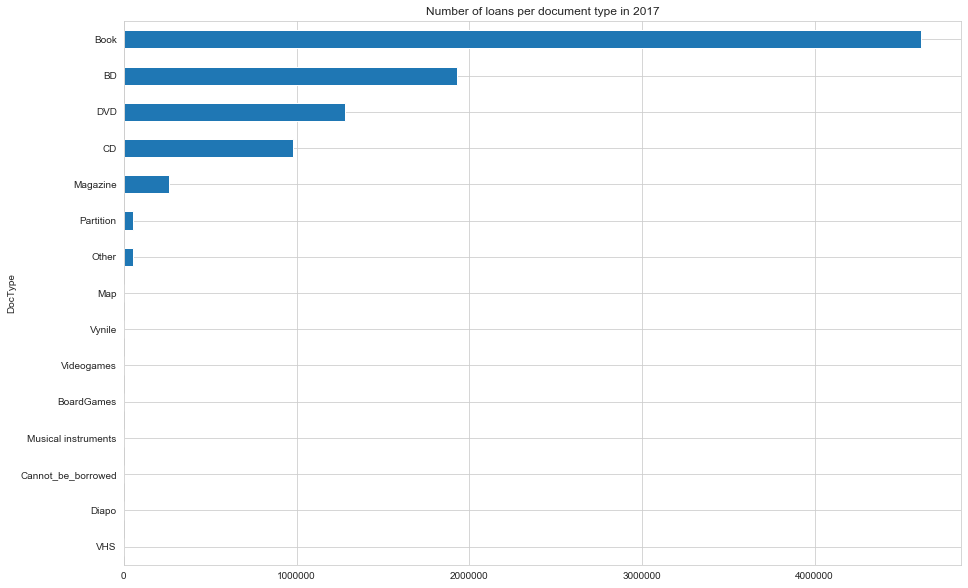

In [44]:
dataBook.groupby('DocType')['Nombre_de_prêts_2017'].agg('sum').sort_values(ascending=True).plot(kind='barh',figsize=(15,10))

plt.title('Number of loans per document type in 2017')

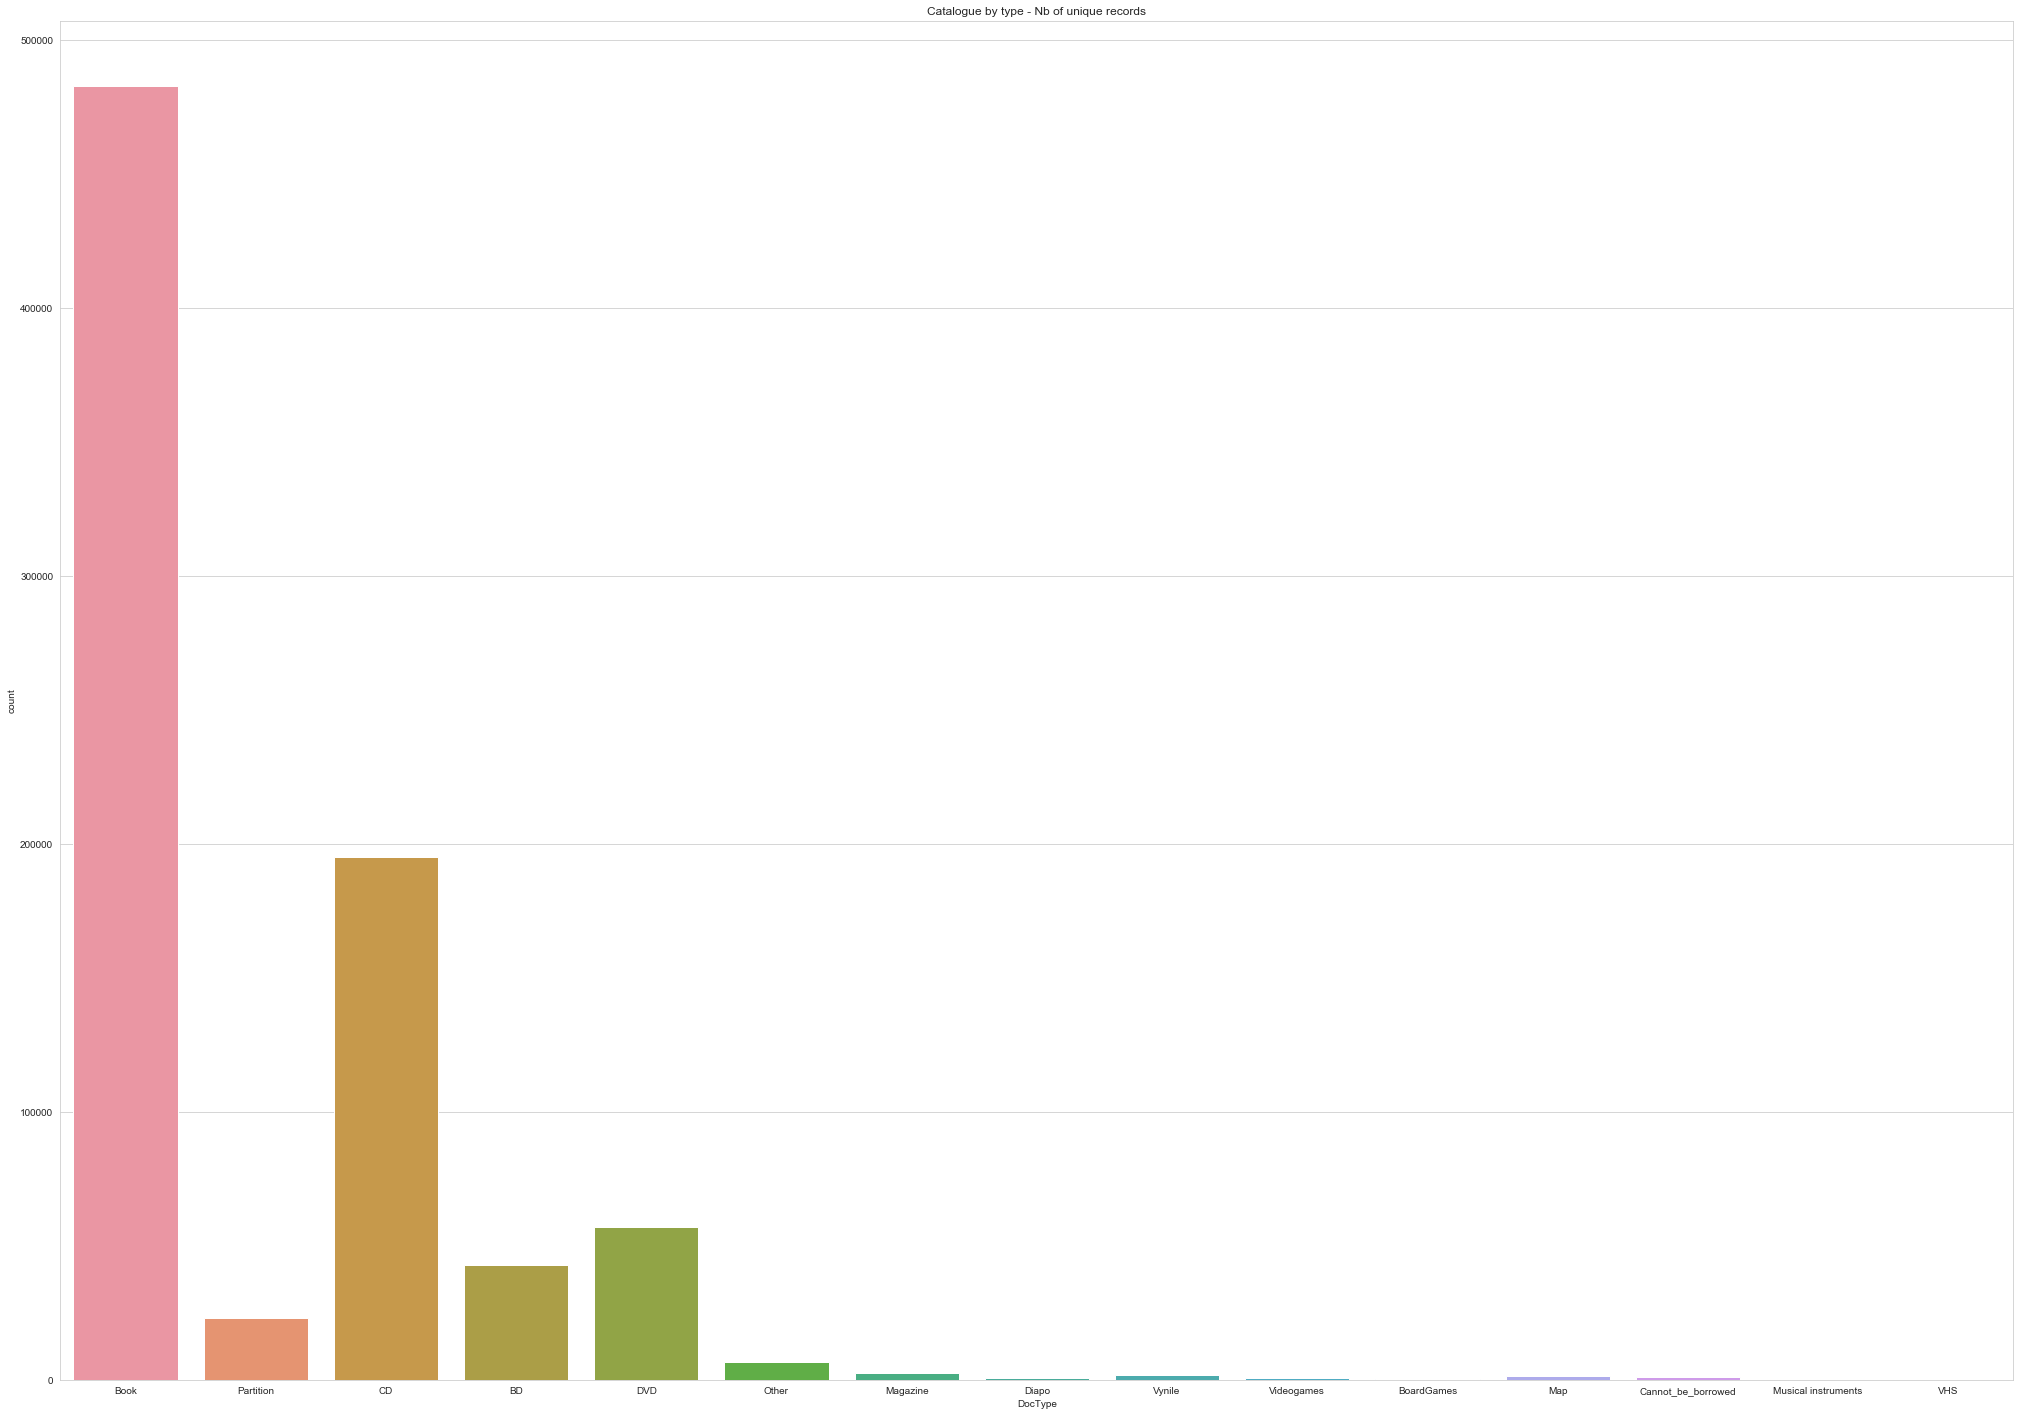

In [43]:
fig, ax = plt.subplots(figsize=(35,25))
sns.countplot(dataBook['DocType'])
plt.title('Catalogue by type - Nb of unique records')
plt.show()

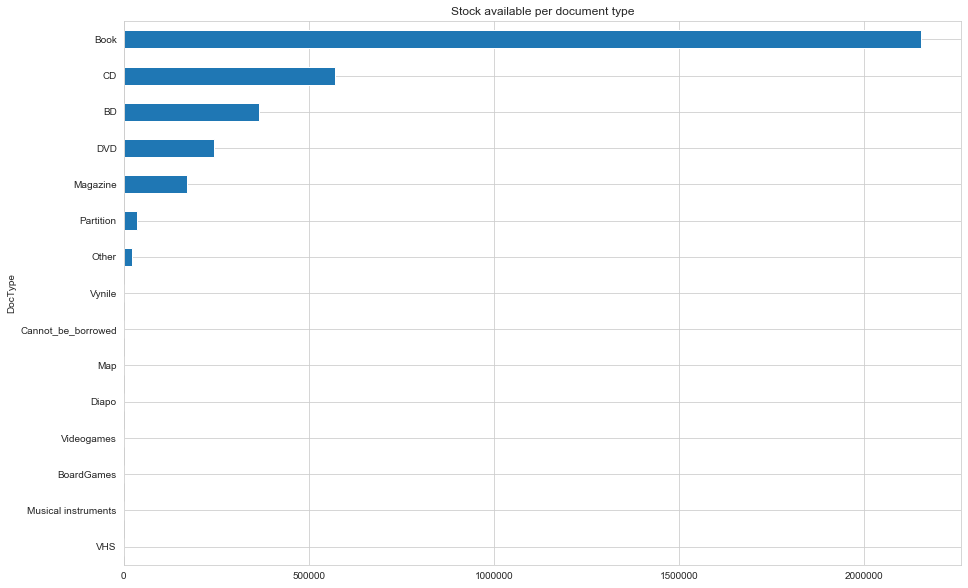

DocType
Book                   2152731.0
CD                      570734.0
BD                      363790.0
DVD                     242277.0
Magazine                169510.0
Partition                36064.0
Other                    23001.0
Vynile                    1659.0
Cannot_be_borrowed        1468.0
Map                       1356.0
Diapo                      923.0
Videogames                 739.0
BoardGames                 721.0
Musical instruments         25.0
VHS                          5.0
Name: Nombre_d'exemplaires, dtype: float64

In [45]:


# Plot Number of loans by document type and  total number of document available('Nombre d'examplaires')
dataBook.groupby('DocType')["Nombre_d'exemplaires"].agg('sum').sort_values(ascending=True).plot(kind='barh',figsize=(15,10))
plt.title('Stock available per document type')
plt.show()
dataBook.groupby('DocType')["Nombre_d'exemplaires"].agg('sum').sort_values(ascending=False)

# TO DO :Plot Number of loans by document type and  total number of document available('Nombre d'examplaires')


In [ ]:
# Plot Number of loans by document type and  total number loans

 

In [46]:
#Look at the different types/format of info in Date columns
# Date give us more or less the age of the book (printing, edition,)
dataBook['Date'].value_counts().to_dict()

{'2004': 25126,
 '2017': 24924,
 '2003': 23471,
 '2002': 21567,
 '2001': 19751,
 '2000': 18409,
 '2005': 18177,
 '1999': 17394,
 '2012': 17081,
 '2006': 17042,
 '2016': 16909,
 '2007': 16603,
 '1998': 16184,
 '2011': 15227,
 '1997': 14965,
 '2015': 14721,
 '2013': 14272,
 '2014': 14250,
 '2008': 14098,
 '1996': 13789,
 '1995': 13665,
 '1994': 13337,
 '2010': 13291,
 'DL 2015': 12616,
 '1992': 12588,
 '1990': 12172,
 '1993': 12131,
 '1991': 12121,
 '2009': 12069,
 '1989': 10732,
 'DL 2016': 9864,
 'impr. 2013': 9474,
 '1988': 9292,
 'impr. 2010': 9060,
 '1987': 8354,
 'impr. 2009': 8346,
 '2018': 8341,
 'impr. 2011': 8128,
 'impr. 2008': 8086,
 'impr. 2012': 7975,
 '1986': 7528,
 'impr. 2007': 7518,
 'DL 2014': 7309,
 'impr. 2014': 6990,
 'DL 2010': 6773,
 'DL 2013': 6557,
 'DL 2009': 6553,
 'DL 2008': 6486,
 'impr. 2006': 6247,
 '1985': 6196,
 'DL 2011': 6086,
 'DL 2012': 5732,
 'DL 2007': 5599,
 '1984': 5435,
 'impr. 2005': 4780,
 'DL 2006': 4719,
 '1983': 4490,
 '1982': 3976,
 'DL 20

In [47]:
dataBook['Date'].isna().sum()

4725

In [48]:
#fill missing date with na
dataBook['Date'].fillna('UnknownDate',inplace=True)

In [49]:
# Format of Date are pretty different. Some values are not complete or not data

#Action:correct date to Year only

#check if string contains a number
def hasNumbers(inputString):
    return bool(re.search(r'\d', inputString))

# find all date or date like (finding digit)
def findDate(x):
    if hasNumbers(x):
        return re.findall(r'\d+',x)
    else:
        return x

def findDate2(x):
    if hasNumbers(x):
        return re.findall(r'\d+',x)
    else:
        return 'Unknown'

def findDate3(x):
    if hasNumbers(x):
        return re.findall(r'\d+',x)
    else:
        return 'Unknown'

In [50]:
dataBook['DateAge']=dataBook['Date'].map(lambda x : findDate(x))

In [ ]:
dataBook['DateAge'].value_counts()

In [ ]:
dataBook['Langue'].isna().sum()

In [ ]:
dataBook['Langue'].value_counts()

In [ ]:
dataBook[dataBook['Langue'].isna()]

In [51]:
dataBook['Langue'].fillna('Unknown',inplace=True)


In [ ]:
dataBook['Langue'].value_counts()

In [80]:
dataBook.groupby('Langue')['Nombre_de_prêts_2017'].agg('sum').map(lambda x : x*100/dataBook['Nombre_de_prêts_2017'].sum()).sort_values(ascending=False).lt(0.25)

Langue
français                 False
Unknown                  False
anglais                  False
sans                     False
multilingue              False
                         ...  
gothique                  True
espéranto                 True
dakota                    True
couchitiques, langues     True
kpellé                    True
Name: Nombre_de_prêts_2017, Length: 219, dtype: bool

In [81]:
def GroupOther3(col):
    
    selection=dataBook.groupby(col)['Nombre_de_prêts_2017'].agg('sum').map(lambda x : x*100/dataBook['Nombre_de_prêts_2017'].sum()).sort_values(ascending=False).lt(0.25)

    return np.where(dataBook[col].isin(selection[selection==True].index) ,'Other',dataBook[col])

In [82]:
def GroupOther(col):
    selection=(dataBook[col].value_counts(normalize=True)*100).lt(0.5)
    return np.where(dataBook[col].isin(selection[selection==True].index) ,'Other',dataBook[col])

In [83]:
#Create new columns Language
dataBook['Language']=dataBook['Langue']


In [84]:
dataBook['Language']=GroupOther3('Langue')


In [86]:
dataBook.Language=dataBook['Language'].str.replace('sans','Unknown')
dataBook.Language=dataBook['Language'].str.replace('Unknown','Other')
dataBook.Language=dataBook['Language'].str.replace('multilingue','Other')

In [87]:
dataBook['Language'].value_counts()

français    559709
Other       142327
anglais      90506
allemand      8338
italien       8165
espagnol      6486
Name: Language, dtype: int64

In [88]:
dataBook['Language'].isna().sum()

0

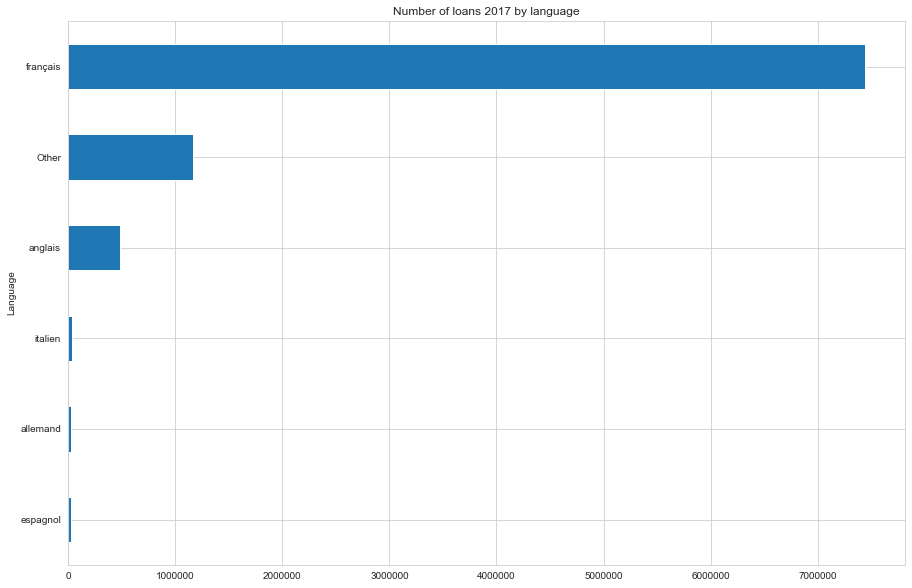

Language
français    7442654.0
Other       1163747.0
anglais      486925.0
italien       33535.0
allemand      26969.0
espagnol      26646.0
Name: Nombre_de_prêts_2017, dtype: float64

In [90]:

# Plot Number of loans by language
dataBook.groupby('Language')["Nombre_de_prêts_2017"].agg('sum').sort_values(ascending=True).plot(kind='barh',figsize=(15,10))
plt.title('Number of loans 2017 by language')
plt.show()
dataBook.groupby('Language')["Nombre_de_prêts_2017"].agg('sum').sort_values(ascending=False)



In [ ]:
#dataBook['Edition'].value_counts()

In [91]:
to_drop.append('Edition')

In [92]:
dataBook['Editeur'].isna().sum()

0

In [93]:
dataBook['Editeur'].value_counts()

Gallimard                                           26397
Flammarion                                          11152
Presses universitaires de France                     6061
A. Michel                                            5763
Fayard                                               5720
                                                    ...  
Zhongguo hai guan, impr.                                1
Disques Pierre Vérany                                   1
Activision;Activision Blizzard France [distrib.]        1
Philipp Reclam jun.                                     1
False Idols/!K7                                         1
Name: Editeur, Length: 89451, dtype: int64

In [77]:
dataBook['Editeur'].unique()

array(["Documentation française ;Ministère des affaires étrangères, Direction de la presse, de l'information et de la communication",
       'Diderot éditeur, arts et sciences', 'Plon', ..., 'Éd. Solilang',
       'rough Trade', 'Makafresh'], dtype=object)

In [94]:
dataBook['Editeur'].fillna('Unknown',inplace=True)

In [96]:
#dataBook.groupby('Editeur')['Nombre_de_prêts_2017'].agg('sum').map(lambda x : x*100/dataBook['Nombre_de_prêts_2017'].sum()).sort_values(ascending=False).lt(0.25)



In [97]:
#selectop, depending on count of records
dataBook['Publisher']=dataBook['Editeur']
dataBook['Publisher']=GroupOther('Editeur')
    

In [98]:
dataBook.Publisher.value_counts()

Other                               714302
Gallimard                            26397
Flammarion                           11152
Presses universitaires de France      6061
A. Michel                             5763
Fayard                                5720
Éd. du Seuil                          5130
Unknown                               5012
Hachette                              4703
Nathan                                4577
Casterman                             4526
R. Laffont                            4524
Pocket                                4484
Glénat                                4455
Librairie générale française          4437
Actes Sud                             4288
Name: Publisher, dtype: int64

In [99]:
dataBook['Format'].value_counts()

1 disque compact | 1 brochure                                                                       23583
1 disque compact | DDD | 1 brochure                                                                 21253
1 compact | 1 brochure                                                                              20918
1 compact | DDD | 1 brochure                                                                        13159
1 compact | 1 dépliant                                                                               8168
                                                                                                    ...  
1 vol. (143 p.) | ill. en noir et en coul., couv. ill. en coul. | 23 x 29 cm                            1
1 disque compact (40 min 20 s) | 1 brochure ([12] p.) : ill. en coul. ; 12 cm                           1
1 DVD vidéo  | coul, son.                                                                               1
63 p. | ill. en noir et en coul., cartes | 30 

In [100]:
to_drop.append('Format')

In [102]:
dataBook['Collection'].value_counts().head(10)

Du monde entier             1562
Roman                        910
Pour les nuls                697
Grands détectives            674
Bouquins                     615
Littérature étrangère        570
Le routard                   545
10-18 | Domaine étranger     530
Neuf                         496
Médium                       487
Name: Collection, dtype: int64

In [103]:
dataBook['Collection'].isna().sum()
dataBook['Collection']=dataBook['Collection'].fillna('Unknown')

In [104]:
dataBook['New_Collection']=dataBook['Collection']
dataBook['New_Collection']=np.where(dataBook['Collection'].isin(dataBook['Collection'].value_counts().head(15).index) ,dataBook['Collection'],'Other')

In [ ]:
dataBook['New_Collection'].value_counts()

In [ ]:
dataBook['Titre_de_série'].value_counts()

In [105]:
to_drop.extend(['Titre_de_série','N°','Dates','EAN','ISSN','New_Collection','Collection','Cote_majoritaire'])

In [ ]:
dataBook.shape

In [ ]:
to_drop

In [106]:
df=dataBook.drop(columns=to_drop)


In [ ]:
df

In [107]:
dataBook.shape, df.shape

((815531, 111), (815531, 81))

In [ ]:
#Reduce scope of study to Books, BD

In [ ]:
#df1=df.drop(dataBook.iloc[:,38:97],axis=1)

In [ ]:
#df1.shape

In [ ]:
#df1.head()

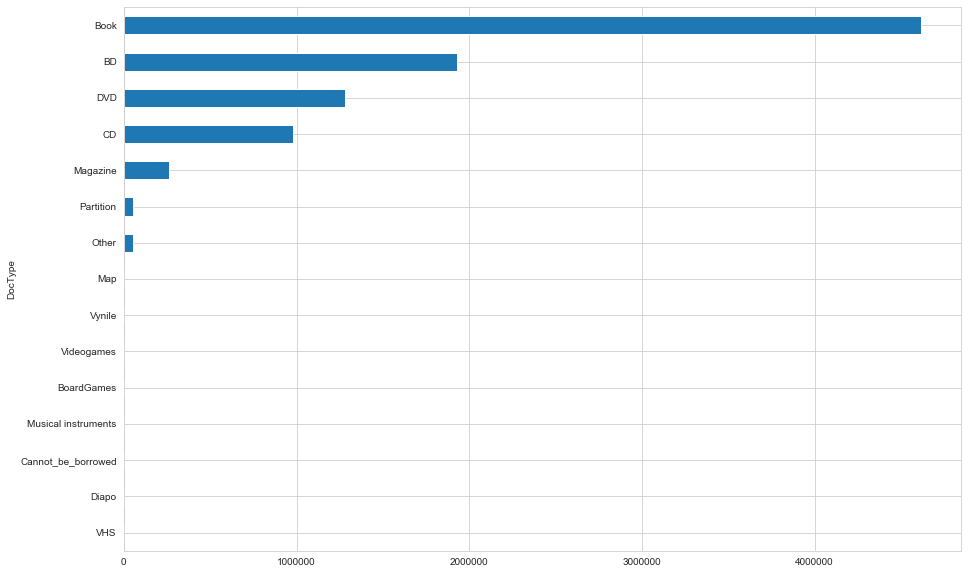

In [108]:
df.groupby('DocType')['Nombre_de_prêts_2017'].agg('sum').sort_values(ascending=True).plot(kind='barh',figsize=(15,10))

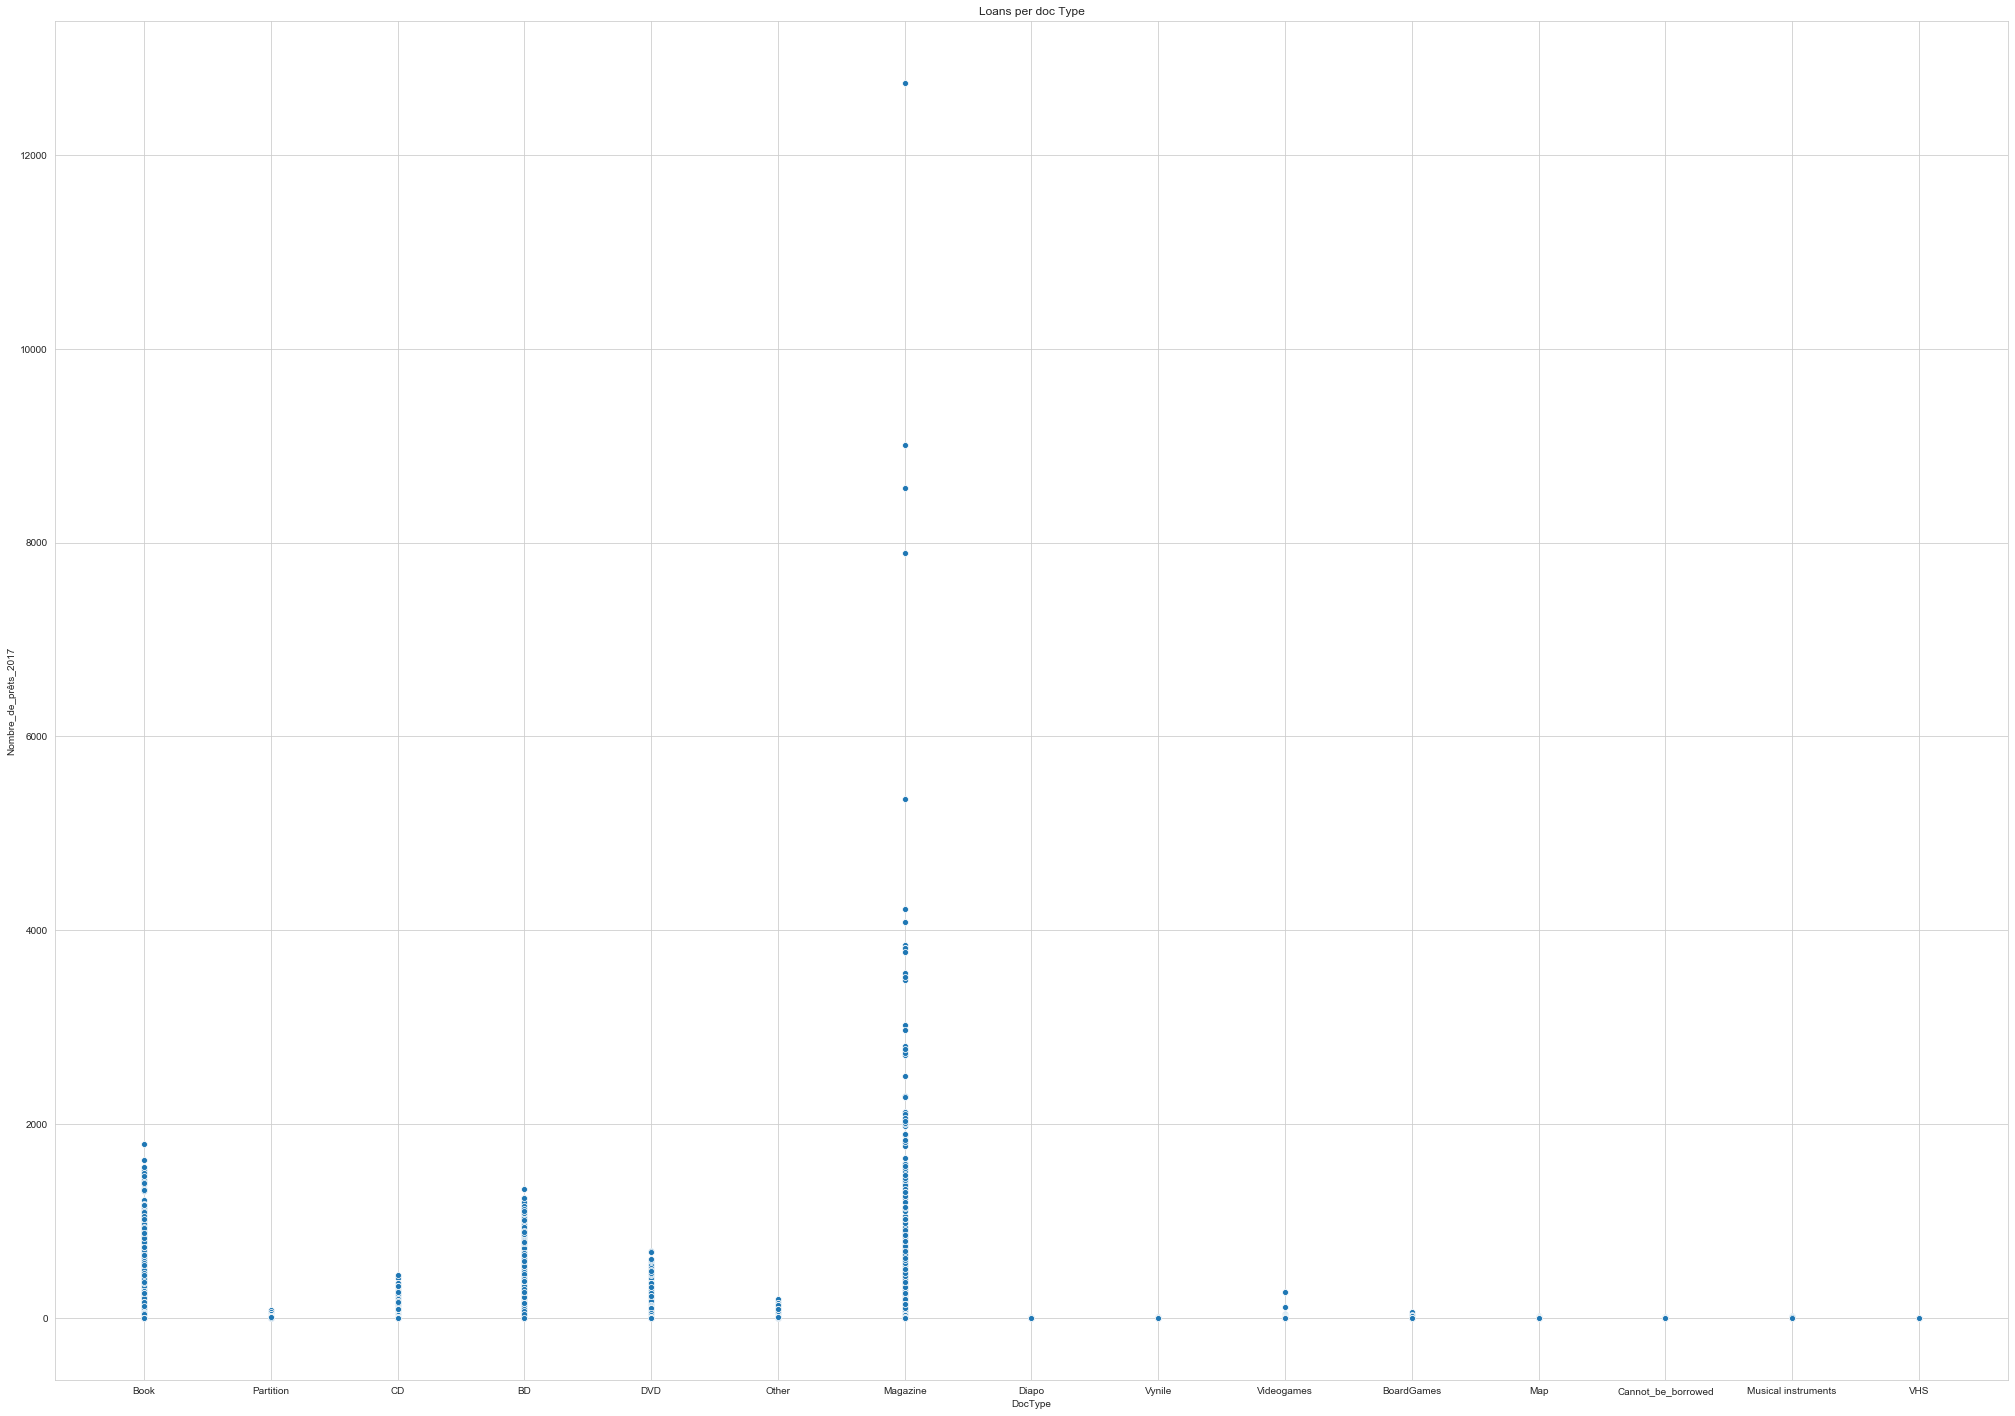

In [110]:
fig, ax = plt.subplots(figsize=(35,25))
sns.scatterplot(df.DocType,df['Nombre_de_prêts_2017'])
plt.title('Loans per doc Type')
plt.show()

In [111]:
df[df.DocType=='Magazine']['Nombre_de_prêts_2017'].max()

12745.0

In [112]:
#magazine le plus emprunté
df[(df.DocType=='Magazine')&(df['Nombre_de_prêts_2017']==12745.0)]

,N°_de_notice,ISBN,Langue,Titre,Editeur,Date,Type_de_document,Nombre_de_localisations,Nombre_de_prêt_total,Nombre_de_prêts_2017,...,Vandamme,Vaugirard,Co-auteur,Author,Author_secondary,Co_Author,DocType,DateAge,Language,Publisher
703815,676189,NaN,français,J'aime lire,Bayard-Presse,1976-,Revue jeunesse,54.0,48009,12745,...,22.0,36.0,NaN,UnknownAuthor,UnknownAuthor,UnknownAuthor,Magazine,[1976],français,Other


In [115]:
df[(df.Titre=="J'aime lire")]["Nombre_d'exemplaires"]

703815    2365
Name: Nombre_d'exemplaires, dtype: object

In [116]:
df[(df.Titre=="J'aime lire")]["Nombre_d'exemplaires"]/54

703815    43.7963
Name: Nombre_d'exemplaires, dtype: object

In [117]:
df['DateAge']=df['Date'].map(lambda x : findDate2(x))

In [118]:
df['DateAge']=df.DateAge.astype(str).str.replace('[','').str.replace(']','').str.replace("'",'')

In [119]:
df['DateAge']

0         2003
1         1998
2         1977
3         1997
4         1984
          ... 
815529    2008
815530    2007
815531    2005
815532    2008
815533    2009
Name: DateAge, Length: 815531, dtype: object

In [120]:
list(df.DateAge.value_counts().index)

['2013',
 '2012',
 '2007',
 '2010',
 '2008',
 '2011',
 '2014',
 '2009',
 '2006',
 '2015',
 '2005',
 '2016',
 '2004',
 '2017',
 '2003',
 '2002',
 '2001',
 '2000',
 '1999',
 '1998',
 '1997',
 '1996',
 '1995',
 '1994',
 '1992',
 '1990',
 '1993',
 '1991',
 '1989',
 '1988',
 '1987',
 '2018',
 '1986',
 'Unknown',
 '1985',
 '1984',
 '1983',
 '1982',
 '1980',
 '1981',
 '1979',
 '1978',
 '1977',
 '1976',
 '1975',
 '1973',
 '1974',
 '1972',
 '1971',
 '1970',
 '1969',
 '1968',
 '1967',
 '1966',
 '19',
 '1965',
 '1964',
 '1963',
 '1961',
 '1962',
 '1960',
 '1959',
 '1958',
 '1957',
 '1956',
 '1955',
 '1954',
 '199',
 '1951',
 '1947',
 '1952',
 '1953',
 '1950',
 '1948',
 '1949',
 '198',
 '1946',
 '200',
 '1925',
 '1931',
 '1930',
 '1927',
 '1929',
 '2017, 2017',
 '1945',
 '1934',
 '1937',
 '1932',
 '1938',
 '1928',
 '1926',
 '1935',
 '2009, 2009',
 '2016, 2016',
 '1936',
 '2013, 2013',
 '1933',
 '2011, 2011',
 '2012, 2012',
 '1942',
 '1924',
 '1939',
 '2014, 2014',
 '1941',
 '1923',
 '1943',
 '1921

In [ ]:
df.head()

In [121]:
df.isna().sum()

N°_de_notice         0
ISBN            323242
Langue               0
Titre                0
Editeur              0
                 ...  
Co_Author            0
DocType              0
DateAge              0
Language             0
Publisher            0
Length: 81, dtype: int64

In [ ]:
df.Nombre_de_localisations=df.Nombre_de_localisations.astype('int')

In [175]:
df["Nombre_d'exemplaires"]=df["Nombre_d'exemplaires"].astype('int')

In [124]:
# Dummies
df.Language.unique()

array(['français', 'anglais', 'Other', 'allemand', 'espagnol', 'italien'],
      dtype=object)

In [125]:
Dummies_NA.append('Language')

In [126]:
df.Nombre_de_prêts_2017=df.Nombre_de_prêts_2017.astype('int')

In [131]:
df.Catégorie_statistique_1.value_counts()

LFRA Litterature francaise          92818
LNAM Litterature nord-americaine    32876
LBDE Bandes dessinees               29498
LALB Albums                         28094
LBRI Litterature britannique        25858
                                    ...  
240                                     1
249                                     1
Vie pratique sauf cuisine               1
Cuisine, alimentation                   1
Sport                                   1
Name: Catégorie_statistique_1, Length: 342, dtype: int64

In [136]:
def GroupOther4(col):
    
    selection=dataBook.groupby(col)['Nombre_de_prêts_2017'].agg('sum').map(lambda x : x*100/dataBook['Nombre_de_prêts_2017'].sum()).sort_values(ascending=False).lt(1)

    return np.where(dataBook[col].isin(selection[selection==True].index) ,'Other',dataBook[col])

In [137]:
df['Categories_stat']=df.Catégorie_statistique_1

In [138]:
df['Categories_stat']=GroupOther4('Catégorie_statistique_1')

In [139]:
df['Categories_stat'].value_counts()

Other                               554617
LFRA Litterature francaise           92818
LNAM Litterature nord-americaine     32876
LBDE Bandes dessinees                29498
LALB Albums                          28094
LBRI Litterature britannique         25858
CNAM Cinema nord-americain           16831
D911 Guides de voyage, tourisme      12926
LMAN Mangas                          11823
CFRA Cinema francais                 10190
Name: Categories_stat, dtype: int64

In [140]:
Dummies_NA.append('Categories_stat')

In [141]:
df.DocType.unique()

array(['Book', 'Partition', 'CD', 'BD', 'DVD', 'Other', 'Magazine',
       'Diapo', 'Vynile', 'Videogames', 'BoardGames', 'Map',
       'Cannot_be_borrowed', 'Musical instruments', 'VHS'], dtype=object)

In [142]:
Dummies_NA.append('DocType')

In [143]:
df.Publisher.unique()

array(['Other', 'Presses universitaires de France', 'Fayard', 'Hachette',
       'Unknown', 'Gallimard', 'Librairie générale française', 'Nathan',
       'Éd. du Seuil', 'Flammarion', 'Actes Sud', 'Casterman', 'Pocket',
       'R. Laffont', 'Glénat', 'A. Michel'], dtype=object)

In [144]:
Dummies_NA.append('Publisher')

In [145]:
Dummies_NA

['Language', 'Categories_stat', 'DocType', 'Publisher']

In [146]:
df.columns

Index(['N°_de_notice', 'ISBN', 'Langue', 'Titre', 'Editeur', 'Date',
       'Type_de_document', 'Nombre_de_localisations', 'Nombre_de_prêt_total',
       'Nombre_de_prêts_2017', 'Nombre_de_prêt_année_2018_au_26_juillet_2018',
       'Nombre_d'exemplaires', 'Catégorie_statistique_1',
       'Catégorie_statistique_2', 'Aimé_Césaire', 'Amélie', 'André_Malraux',
       'Andrée_Chedid', 'Arthur_Rimbaud', 'Assia_Djebar', 'Batignolles',
       'Benjamin_Rabier', 'Buffon', 'Canopée_-_la_fontaine', 'Chaptal',
       'Charlotte_Delbo', 'Claude_Lévi-Strauss', 'Colette_Vivier',
       'Courcelles', 'Couronnes_-_Naguib_Mahfouz', 'Crimée', 'Diderot',
       'Drouot', 'Edmond_Rostand', 'Europe', 'Faidherbe', 'Fessart',
       'François_Villon', 'Françoise_Sagan', 'Georges_Brassens',
       'Germaine_Tillion', 'Glacière', 'Goutte_d'Or', 'Gutenberg',
       'Hélène_Berr', 'Hergé', 'Heure_Joyeuse', 'Italie',
       'Jacqueline_de_Romilly', 'Jean-Pierre_Melville', 'Lancry',
       'Louise_Michel', 'Margu

In [176]:
df1=df[['Language','Publisher','Categories_stat','DocType','Nombre_de_localisations',"Nombre_d'exemplaires",'Nombre_de_prêts_2017']]

In [177]:
df1.shape

(815531, 7)

In [178]:
df1=pd.get_dummies(data=df1, columns=Dummies_NA,drop_first=True)

In [179]:
df1

,Nombre_de_localisations,Nombre_d'exemplaires,Nombre_de_prêts_2017,Language_allemand,Language_anglais,Language_espagnol,Language_français,Language_italien,Categories_stat_CNAM Cinema nord-americain,"Categories_stat_D911 Guides de voyage, tourisme",...,Publisher_Glénat,Publisher_Hachette,Publisher_Librairie générale française,Publisher_Nathan,Publisher_Other,Publisher_Pocket,Publisher_Presses universitaires de France,Publisher_R. Laffont,Publisher_Unknown,Publisher_Éd. du Seuil
0,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,2,2,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,3,3,6,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,2,2,3,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815529,1,1,6,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
815530,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
815531,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
815532,3,3,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [171]:
df1['Nombre_de_prêts_2017'].sum()

9180476

# Modelling

In [164]:
from statsmodels.formula.api import ols
from statsmodels.api import OLS
from statsmodels.api import add_constant

In [180]:
y=df1['Nombre_de_prêts_2017']
X=df1.drop('Nombre_de_prêts_2017',axis=1)

In [181]:
model=OLS(y,X)

In [182]:
model_fit=model.fit()

In [183]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     Nombre_de_prêts_2017   R-squared (uncentered):                   0.621
Model:                              OLS   Adj. R-squared (uncentered):              0.621
Method:                   Least Squares   F-statistic:                          2.964e+04
Date:                  Mon, 20 Jul 2020   Prob (F-statistic):                        0.00
Time:                          02:18:40   Log-Likelihood:                     -3.9296e+06
No. Observations:                815531   AIC:                                  7.859e+06
Df Residuals:                    815486   BIC:                                  7.860e+06
Df Model:                            45                                                  
Covariance Type:              nonrobust                                                  
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Nombre_de_localisations                              2.2403      0.007    344.520      0.000       2.228       2.253
Nombre_d'exemplaires                                 1.7613      0.003    703.018      0.000       1.756       1.766
Language_allemand                                   -1.3289      0.338     -3.927      0.000      -1.992      -0.666
Language_anglais                                     0.1684      0.129      1.301      0.193      -0.085       0.422
Language_espagnol                                   -0.5137      0.382     -1.345      0.179      -1.262       0.235
Language_français                                   -1.5462      0.110    -14.054      0.000      -1.762      -1.331
Language_italien                                    -0.6982      0.342     -2.044      0.041      -1.368      -0.029
Categories_stat_CNAM Cinema nord-americain          -2.1450      0.353     -6.073      0.000      -2.837      -1.453
Categories_stat_D911 Guides de voyage, tourisme     -7.3351      0.399    -18.373      0.000      -8.118      -6.553
Categories_stat_LALB Albums                         -5.7719      0.350    -16.509      0.000      -6.457      -5.087
Categories_stat_LBDE Bandes dessinees               12.3784      0.361     34.276      0.000      11.671      13.086
Categories_stat_LBRI Litterature britannique       -12.3399      0.353    -35.006      0.000     -13.031     -11.649
Categories_stat_LFRA Litterature francaise         -10.7561      0.313    -34.328      0.000     -11.370     -10.142
Categories_stat_LMAN Mangas                          5.2115      0.427     12.212      0.000       4.375       6.048
Categories_stat_LNAM Litterature nord-americaine   -11.9021      0.341    -34.950      0.000     -12.570     -11.235
Categories_stat_Other                              -11.1306      0.293    -37.934      0.000     -11.706     -10.555
DocType_BoardGames                                   2.3225      1.499      1.549      0.121      -0.616       5.261
DocType_Book                                        -0.8599      0.325     -2.644      0.008      -1.497      -0.223
DocType_CD                                          -0.4245      0.331     -1.282      0.200      -1.073       0.224
DocType_Cannot_be_borrowed                          -0.0418      0.984     -0.043      0.966      -1.970       1.886
DocType_DVD                                          7.7517      0.331     23.402      0.000       7.102       8.401
DocType_Diapo                                       -0.5075      1.333     -0.381      0.704      -3.121       2.106
DocType_Magazine                     

In [ ]:
LS Regression Results
Dep. Variable:	Nombre_de_prêts_2017	R-squared (uncentered):	0.621
Model:	OLS	Adj. R-squared (uncentered):	0.621
Method:	Least Squares	F-statistic:	2.964e+04
Date:	Mon, 20 Jul 2020	Prob (F-statistic):	0.00
Time:	02:18:40	Log-Likelihood:	-3.9296e+06
No. Observations:	815531	AIC:	7.859e+06
Df Residuals:	815486	BIC:	7.860e+06
Df Model:	45		
Covariance Type:	nonrobust	

In [184]:
OLS(y,add_constant(X)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Nombre_de_prêts_2017   R-squared:                       0.599
Model:                              OLS   Adj. R-squared:                  0.599
Method:                   Least Squares   F-statistic:                 2.708e+04
Date:                  Mon, 20 Jul 2020   Prob (F-statistic):               0.00
Time:                          02:27:12   Log-Likelihood:            -3.9296e+06
No. Observations:                815531   AIC:                         7.859e+06
Df Residuals:                    815485   BIC:                         7.860e+06
Df Model:                            45                                         
Covariance Type:              nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                                2.0708      0.681      3.043      0.002       0.737       3.405
Nombre_de_localisations                              2.2391      0.007    343.793      0.000       2.226       2.252
Nombre_d'exemplaires                                 1.7612      0.003    702.977      0.000       1.756       1.766
Language_allemand                                   -1.3510      0.338     -3.991      0.000      -2.014      -0.688
Language_anglais                                     0.1404      0.130      1.082      0.279      -0.114       0.395
Language_espagnol                                   -0.5396      0.382     -1.413      0.158      -1.288       0.209
Language_français                                   -1.6219      0.113    -14.379      0.000      -1.843      -1.401
Language_italien                                    -0.7185      0.342     -2.103      0.035      -1.388      -0.049
Categories_stat_CNAM Cinema nord-americain          -2.5823      0.381     -6.772      0.000      -3.330      -1.835
Categories_stat_D911 Guides de voyage, tourisme     -7.8713      0.436    -18.038      0.000      -8.727      -7.016
Categories_stat_LALB Albums                         -6.3148      0.393    -16.088      0.000      -7.084      -5.545
Categories_stat_LBDE Bandes dessinees               11.1357      0.545     20.426      0.000      10.067      12.204
Categories_stat_LBRI Litterature britannique       -12.8957      0.397    -32.482      0.000     -13.674     -12.118
Categories_stat_LFRA Litterature francaise         -11.3060      0.362    -31.257      0.000     -12.015     -10.597
Categories_stat_LMAN Mangas                          3.9640      0.592      6.698      0.000       2.804       5.124
Categories_stat_LNAM Litterature nord-americaine   -12.4619      0.387    -32.196      0.000     -13.221     -11.703
Categories_stat_Other                              -11.6790      0.344    -33.916      0.000     -12.354     -11.004
DocType_BoardGames                                   1.5741      1.519      1.036      0.300      -1.403       4.552
DocType_Book                                        -1.6067      0.407     -3.944      0.000      -2.405      -0.808
DocType_CD                                          -1.2091      0.420     -2.882      0.004      -2.031      -0.387
DocType_Cannot_be_borrowed                          -0.7953      1.014     -0.784      0.433      -2.783       1.193
DocType_DVD                                          6.8515      0.444     15.428      0.000       5.981       7.722
DocType_Diapo                                       -1.2485      1.355     -0.921      0.357      -3.905       1.408
DocType_Magazine   

# P-Hacking

In [185]:
def func(column, X=X,y=y):
    if column:
        X=X.drop(column, axis=1)
    
    #buildthemodel
    model=OLS(y,add_constant(X))
    model_fit=model.fit()
    display(model_fit.summary())
    return X

In [ ]:
OLS Regression Results
Dep. Variable:	Nombre_de_prêts_2017	R-squared:	0.599
Model:	OLS	Adj. R-squared:	0.599
Method:	Least Squares	F-statistic:	2.708e+04
Date:	Mon, 20 Jul 2020	Prob (F-statistic):	0.00
Time:	02:27:12	Log-Likelihood:	-3.9296e+06
No. Observations:	815531	AIC:	7.859e+06
Df Residuals:	815485	BIC:	7.860e+06
Df Model:	45		
Covariance Type:	nonrobust		


In [198]:
X=func("Publisher_Actes Sud",X)

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Nombre_de_prêts_2017   R-squared:                       0.599
Model:                              OLS   Adj. R-squared:                  0.599
Method:                   Least Squares   F-statistic:                 3.692e+04
Date:                  Mon, 20 Jul 2020   Prob (F-statistic):               0.00
Time:                          02:53:15   Log-Likelihood:            -3.9296e+06
No. Observations:                815531   AIC:                         7.859e+06
Df Residuals:                    815497   BIC:                         7.860e+06
Df Model:                            33                                         
Covariance Type:              nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                                2.6373      0.487      5.417      0.000       1.683       3.592
Nombre_de_localisations                              2.2392      0.007    344.194      0.000       2.226       2.252
Nombre_d'exemplaires                                 1.7612      0.003    703.034      0.000       1.756       1.766
Language_allemand                                   -1.3808      0.334     -4.130      0.000      -2.036      -0.725
Language_français                                   -1.6719      0.100    -16.781      0.000      -1.867      -1.477
Language_italien                                    -0.7581      0.338     -2.245      0.025      -1.420      -0.096
Categories_stat_CNAM Cinema nord-americain          -2.6009      0.381     -6.833      0.000      -3.347      -1.855
Categories_stat_D911 Guides de voyage, tourisme     -7.8752      0.436    -18.048      0.000      -8.730      -7.020
Categories_stat_LALB Albums                         -6.3433      0.392    -16.177      0.000      -7.112      -5.575
Categories_stat_LBDE Bandes dessinees               10.8248      0.452     23.955      0.000       9.939      11.710
Categories_stat_LBRI Litterature britannique       -12.8828      0.397    -32.484      0.000     -13.660     -12.105
Categories_stat_LFRA Litterature francaise         -11.3119      0.362    -31.277      0.000     -12.021     -10.603
Categories_stat_LMAN Mangas                          3.6496      0.504      7.240      0.000       2.662       4.638
Categories_stat_LNAM Litterature nord-americaine   -12.4545      0.387    -32.203      0.000     -13.213     -11.696
Categories_stat_Other                              -11.6874      0.344    -33.944      0.000     -12.362     -11.013
DocType_Book                                        -1.9286      0.251     -7.683      0.000      -2.421      -1.437
DocType_CD                                          -1.5310      0.261     -5.864      0.000      -2.043      -1.019
DocType_DVD                                          6.5163      0.302     21.580      0.000       5.924       7.108
DocType_Magazine                                   -20.3977      0.665    -30.691      0.000     -21.700     -19.095
DocType_Map                                          3.0001      0.872      3.442      0.001       1.292       4.708
DocType_Partition                                    1.3091      0.320      4.092      0.000       0.682       1.936
DocType_Vynile                                       2.3854      0.785      3.037      0.002       0.846       3.925
Publisher_Casterman                                 -3.1926      0.499     -6.403      0.000      -4.170      -2.215
Publisher_Flammario

In [ ]:
# No change of results after removing 12 columns.

In [200]:
X.shape,df1.shape

((815531, 33), (815531, 46))

# Assumptions check

In [204]:
tester=Assumption_Tester_OLS(X,y)

Fitting linear regression

R^2: 0.5990442285890978 

Coefficients
-------------------------------------
Intercept: 2.637338276201991
Nombre_de_localisations: 2.24
Nombre_d'exemplaires: 1.76
Language_allemand: -1.38
Language_français: -1.67
Language_italien: -0.76
Categories_stat_CNAM Cinema nord-americain: -2.6
Categories_stat_D911 Guides de voyage, tourisme: -7.88
Categories_stat_LALB Albums: -6.34
Categories_stat_LBDE Bandes dessinees: 10.82
Categories_stat_LBRI Litterature britannique: -12.88
Categories_stat_LFRA Litterature francaise: -11.31
Categories_stat_LMAN Mangas: 3.65
Categories_stat_LNAM Litterature nord-americaine: -12.45
Categories_stat_Other: -11.69
DocType_Book: -1.93
DocType_CD: -1.53
DocType_DVD: 6.52
DocType_Magazine: -20.4
DocType_Map: 3.0
DocType_Partition: 1.31
DocType_Vynile: 2.39
Publisher_Casterman: -3.19
Publisher_Flammarion: 1.86
Publisher_Gallimard: 1.45
Publisher_Glénat: 5.98
Publisher_Hachette: 10.28
Publisher_Librairie générale française: 7.41
Publisher_N

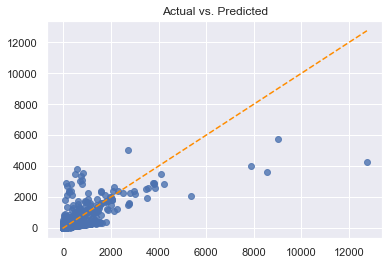

If non-linearity is apparent, consider adding a polynomial term 
		or using box-cox transformation to make X or y follow normal distribution



Building a correlation table


Parameters that are most likely VIOLATE linearity assumption and their correlation with Nombre_de_prêts_2017


Series([], Name: Nombre_de_prêts_2017, dtype: float64)


Parameters that are most likely FOLLOW linearity assumption and their correlation with Nombre_de_prêts_2017


Nombre_de_localisations    0.572209
Nombre_d'exemplaires       0.715164
Name: Nombre_de_prêts_2017, dtype: float64


Assumption 2: Little to no multicollinearity among predictors


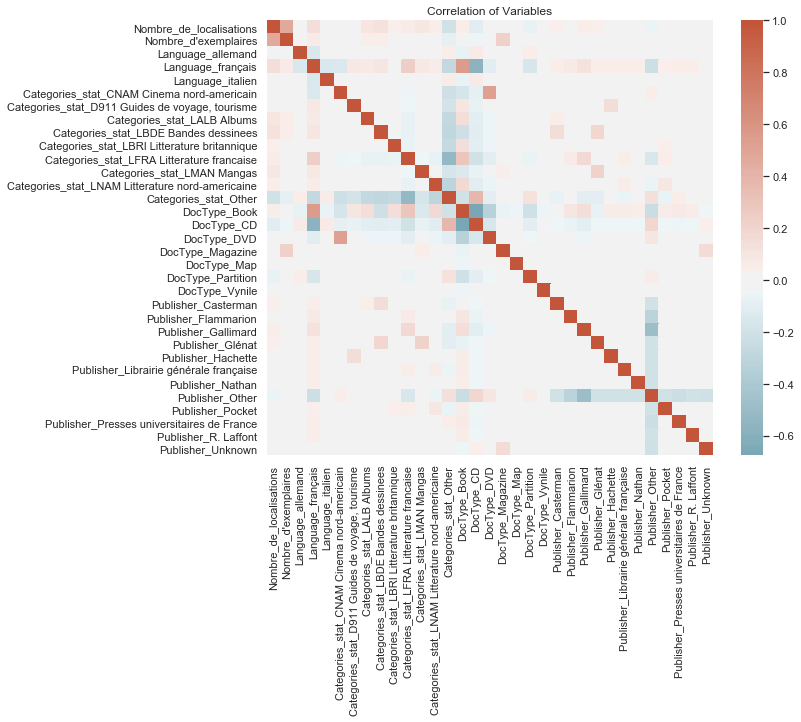

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
Categories_stat_Other: 34.89927288981163
Publisher_Other: 29.04300958884214
DocType_Book: 25.576538565491763
DocType_CD: 10.78368611912744
Categories_stat_LFRA Litterature francaise: 7.113498027868953
Language_français: 5.855205299738418
DocType_DVD: 3.485846173814447
Categories_stat_LNAM Litterature nord-americaine: 3.163141043225632
Categories_stat_LALB Albums: 2.89178216240639
Categories_stat_LBRI Litterature britannique: 2.705585213683894
Categories_stat_LBDE Bandes dessinees: 2.421595761860912
DocType_Partition: 2.1579325533392657
Publisher_Gallimard: 2.0502868525107614
Categories_stat_CNAM Cinema nord-americain: 2.0064655555815367
Nombre_de_localisations: 2.0020755685881917
Categories_stat_D911 Guides de voyage, tourisme: 1.893010953430287
Categories_stat_LMAN Mangas: 1.6316821976265308
Nombre_d'exemp

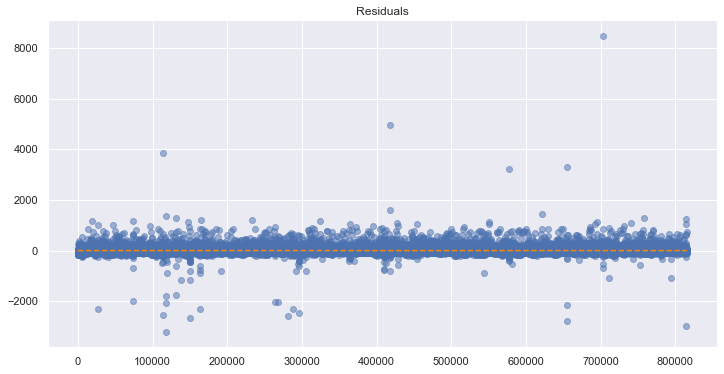

If heteroskedasticity is apparent, confidence intervals and predictions will be affected

Consider removing outliers and preprocessing features - nonlinear transformation can help


{'Lagrange Multiplier': 192110.76777282535,
 'pvalue for LM': 0.0,
 'F stats': 7615.173025935609,
 'pvalue for Fstats': 0.0}

Signs of positive autocorrelation 

Assumption potentially not satisfied 


Assumption 5: The error terms are kinda normally distributed

Using the Anderson-Darling test for normal distribution


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/_adnorm.py:70: RuntimeWarning: divide by zero encountered in log
  s = np.sum((2 * i[sl1] - 1.0) / nobs * (np.log(z) + np.log1p(-z[sl2])),
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/_adnorm.py:70: RuntimeWarning: divide by zero encountered in log1p
  s = np.sum((2 * i[sl1] - 1.0) / nobs * (np.log(z) + np.log1p(-z[sl2])),


p-value from the test - below 0.05 generally means non-normal: 0.0
Residuals are not normally distributed


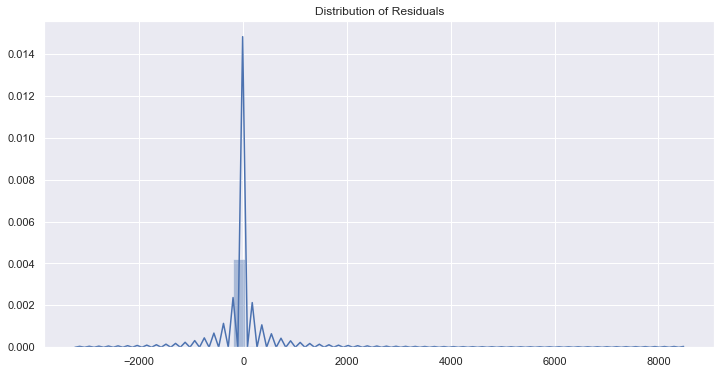


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables
Building a probability plot


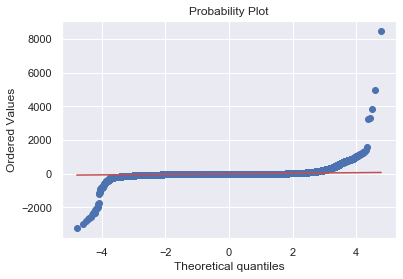

Assumption can be considered as satisfied.


{'Satisfied': ['Linearity', 'Autocorrelation', 'Sub-Normality'],
 'Potentially': ['Multicollinearity', 'Autocorrelation'],
 'Violated': ['Normality']}

In [205]:
tester.run_all()

In [206]:
X.to_csv('X1csv',index=False)
y.to_csv('y1.csv',index=False)

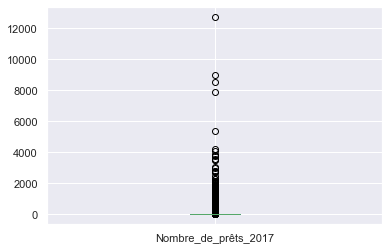

In [215]:
y.plot.box()

In [214]:
#X=X.drop(['Categories_stat_Other','Publisher_Other','DocType_Book'],axis=1)


In [216]:
summary=y.describe()
summary['IQR']=summary['75%']-summary['25%']

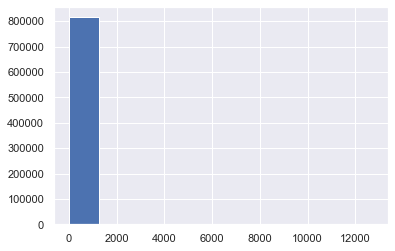

In [217]:
y.hist()